

## Lorenz attractor originally used by [Lorentz system](https://en.wikipedia.org/wiki/Lorenz_system) consists of three differential equations:

\begin{align*}
&\frac{\mathrm{d}x}{\mathrm{d}t} = \sigma(y - x) + u_0,\\[1em]
&\frac{\mathrm{d}y}{\mathrm{d}t} = x(\rho - z) - y,\\[1em]
&\frac{\mathrm{d}z}{\mathrm{d}t} = xy - \beta z - u_1.
\end{align*}


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import scipy.interpolate
from mpl_toolkits.mplot3d import Axes3D
from improve_dmdc import Improved_DMDc_new

# Lorenz system parameters
sigma, rho, beta = 10.0, 28.0, 8.0 / 3.0
integrator_keywords = {'rtol': 1e-12, 'method': 'LSODA', 'atol': 1e-12}

# Lorenz ODE with control
def ode_Lorenz(t, xyz, uu):
    x, y, z = xyz
    dx_dt = sigma * (y - x)
    dy_dt = x * (rho - z) - y
    dz_dt = x * y - beta * z + uu
    return [dx_dt, dy_dt, dz_dt]

# Simulation function
def SciPy_Lorenz(t_begin, t_end, x_init, y_init, z_init, t_space, u_con=None):
    if u_con is not None:
        u_interp = scipy.interpolate.interp1d(t_space, u_con, kind='previous', bounds_error=False, fill_value=(u_con[0], u_con[-1]))
        def ode_fun(t, xyz):
            return ode_Lorenz(t, xyz, u_interp(t))
    else:
        def ode_fun(t, xyz):
            return ode_Lorenz(t, xyz, 0.0)
    num_sol = solve_ivp(ode_fun, [t_begin, t_end], [x_init, y_init, z_init], **integrator_keywords, t_eval=t_space)
    return num_sol.y[0], num_sol.y[1], num_sol.y[2]


In [2]:
# Simulation parameters
t_init, t_end, delta_t = 0, 50, 0.003
x_init, y_init, z_init = 1.0, 1.0, 1.0
N_t = int((t_end - t_init) / delta_t) + 1
t_array = np.linspace(t_init, t_end, N_t)
u_con = (2 * np.sin(t_array) * np.sin(t_array / 10)) ** 2
x_solved, y_solved, z_solved = SciPy_Lorenz(t_begin=t_init, t_end=t_end, x_init=x_init, y_init=y_init, z_init=z_init, t_space=t_array, u_con=u_con)

# Training data
N_train = int(N_t * 0.8)
x_train = x_solved[:N_train]
y_train = y_solved[:N_train]
z_train = z_solved[:N_train]
t_train = t_array[:N_train]
X_data = np.vstack((x_train, y_train, z_train))
U_control = u_con[:N_train-1].reshape(1, -1)

# Apply Improved DMDc
rank_p, rank_r = 20, 10
eigenvalues, modes, recons, bar_A, bar_B, bar_V = Improved_DMDc_new(X_data, U_control, rank_p, rank_r)

# Predict future states
X_data_test = np.vstack((x_solved[N_train-1], y_solved[N_train-1], z_solved[N_train-1])).reshape(3, 1)
z_k = bar_V.T @ X_data_test
future_steps = N_t - N_train + 1
Y_pred = np.zeros((3, future_steps))
z_current = z_k.reshape(-1, 1)

for i in range(future_steps):
    u_current = u_con[N_train-1+i].reshape(1, -1)
    z_next = bar_A @ z_current + bar_B @ u_current
    Y_pred[:, i] = (bar_V @ z_next).reshape(3,)
    z_current = z_next

In [3]:
# Compute RMSE and relative error for each state variable (x, y, z)
def compute_relative_error(original, reconstructed):
    return np.linalg.norm(original - reconstructed, axis=1) / np.linalg.norm(original, axis=1)

def compute_rmse(original, reconstructed):
    return np.sqrt(np.mean((original - reconstructed) ** 2, axis=1))

rel_error = compute_relative_error(X_data[:, :-1], recons)
rmse = compute_rmse(X_data[:, :-1], recons)

for idx, var in enumerate(['x', 'y', 'z']):
    print(f"Relative Error in {var}: {rel_error[idx]:.4f}, RMSE in {var}: {rmse[idx]:.4f}")


Relative Error in x: 0.0138, RMSE in x: 0.1112
Relative Error in y: 0.0138, RMSE in y: 0.1220
Relative Error in z: 0.0004, RMSE in z: 0.0112


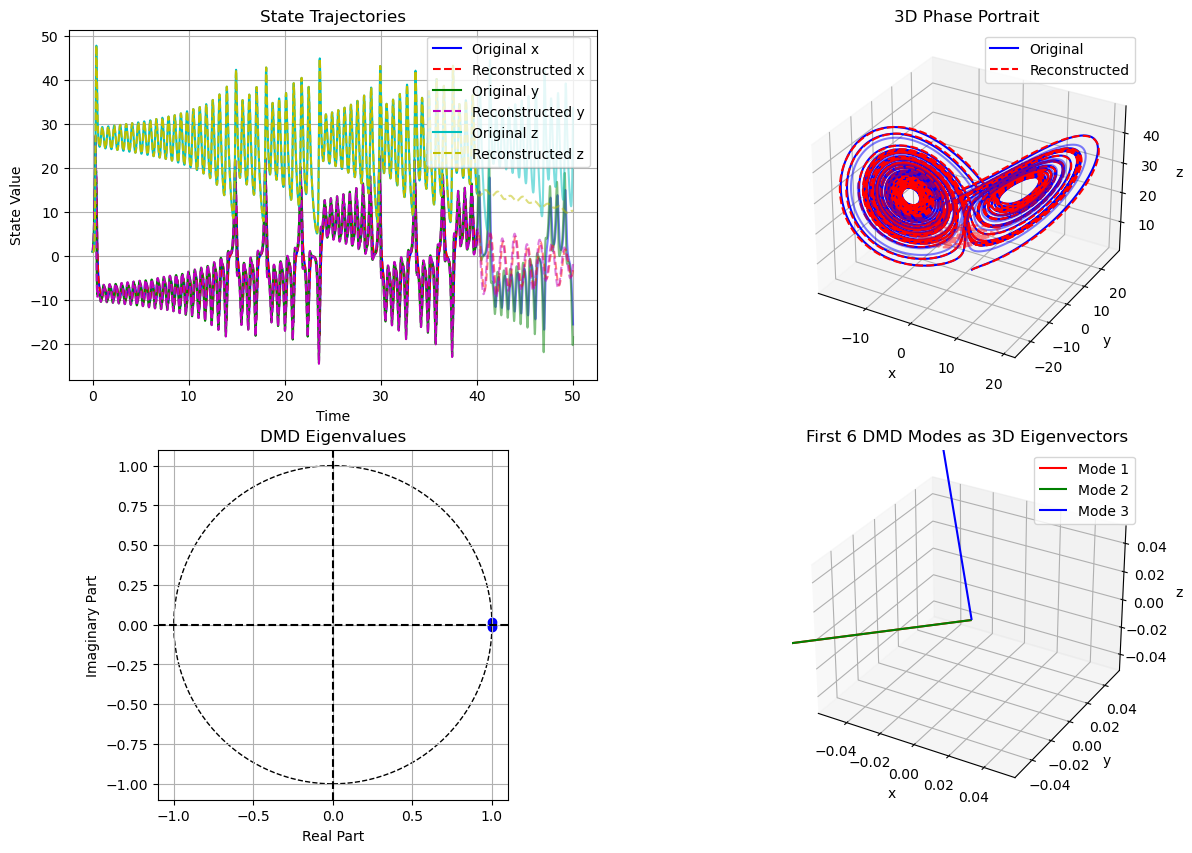

In [4]:
# Visualization
fig = plt.figure(figsize=(15, 10))

# Plot 1: State trajectories
ax1 = fig.add_subplot(221)
ax1.plot(t_array[:N_train-1], X_data[0, :-1], 'b-', label='Original x')
ax1.plot(t_array[:N_train-1], recons[0, :], 'r--', label='Reconstructed x')
ax1.plot(t_array[:N_train-1], X_data[1, :-1], 'g-', label='Original y')
ax1.plot(t_array[:N_train-1], recons[1, :], 'm--', label='Reconstructed y')
ax1.plot(t_array[:N_train-1], X_data[2, :-1], 'c-', label='Original z')
ax1.plot(t_array[:N_train-1], recons[2, :], 'y--', label='Reconstructed z')
ax1.plot(t_array[N_train-1:], x_solved[N_train-1:], 'b-', alpha=0.5) #,label='Original x')
ax1.plot(t_array[N_train-1:], y_solved[N_train-1:], 'g-', alpha=0.5) #, label='Original y')
ax1.plot(t_array[N_train-1:], z_solved[N_train-1:], 'c-', alpha=0.5) #, label='Original z')
ax1.plot(t_array[N_train-1:], Y_pred[0, :], 'r--', alpha=0.5)
ax1.plot(t_array[N_train-1:], Y_pred[1, :], 'm--', alpha=0.5)
ax1.plot(t_array[N_train-1:], Y_pred[2, :], 'y--', alpha=0.5)
ax1.set_title('State Trajectories')
ax1.set_xlabel('Time')
ax1.set_ylabel('State Value')
ax1.legend()
ax1.grid(True)

# Plot 2: 3D Phase portrait
ax2 = fig.add_subplot(222, projection='3d')
ax2.plot(X_data[0, :-1], X_data[1, :-1], X_data[2, :-1], 'b-', label='Original')
ax2.plot(recons[0, :], recons[1, :], recons[2, :], 'r--', label='Reconstructed')
ax2.plot(x_solved[N_train-1:], y_solved[N_train-1:], z_solved[N_train-1:], 'b-', alpha=0.5)
ax2.plot(Y_pred[0, :], Y_pred[1, :], Y_pred[2, :], 'r--', alpha=0.5)
ax2.set_title('3D Phase Portrait')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z')
ax2.legend()

# Plot 3: Eigenvalues
ax3 = fig.add_subplot(223)
ax3.scatter(eigenvalues.real, eigenvalues.imag, c='b', marker='o')
ax3.axhline(0, color='k', linestyle='--')
ax3.axvline(0, color='k', linestyle='--')
circle = plt.Circle((0, 0), 1, color='k', fill=False, linestyle='--')
ax3.add_artist(circle)
ax3.set_xlim([-1.1, 1.1])
ax3.set_ylim([-1.1, 1.1])
ax3.set_title('DMD Eigenvalues')
ax3.set_xlabel('Real Part')
ax3.set_ylabel('Imaginary Part')
ax3.grid(True)
ax3.set_aspect('equal', adjustable='box')


# Plot 4: DMD Modes as 3D eigenvectors (first 6, different colors)
ax4 = fig.add_subplot(224, projection='3d')
num_modes = min(modes.shape[1], 6)  # Plot up to 6 eigenvectors
colors = ['r', 'g', 'b', 'm', 'c', 'y']
for i in range(num_modes):
    vec = modes[:, i].real
    ax4.quiver(0, 0, 0, vec[0], vec[1], vec[2], length=1.0, normalize=True, color=colors[i % len(colors)], label=f'Mode {i+1}')
ax4.set_title('First 6 DMD Modes as 3D Eigenvectors')
ax4.set_xlabel('x')
ax4.set_ylabel('y')
ax4.set_zlabel('z')
ax4.legend()
ax4.grid(True)
# Do not set a fixed projection, allow interactive movement

# plt.tight_layout()
# plt.savefig('lorenz_dmdc_analysis.png')
# plt.close()

# question 

+ why in lorenz system, the dynamic for x and y mostly converges, but the dynamics for z axis did not